In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import torch
import math
from skimage import filters
from scipy import ndimage
import random
import torch
import nibabel as nb
from glob import glob
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from trainer import run_training 
from unetr import UNETR
from scipy.ndimage import zoom
import torch.nn.functional as F
import math
import torch.nn.init as init
import torch.nn as nn
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss, DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete, Compose
from monai.utils.enums import MetricReduction
from functools import partial
from lr_scheduler import LinearWarmupCosineAnnealingLR
from argparse import Namespace
from torchvision.transforms import Compose
from torchvision.transforms import Normalize
import plotly.express as px 
from loading_data import SpinalCordDataset, SpinalCordTransform

In [2]:
args = Namespace(
    checkpoint=None,
    logdir="test_actor_critic",
    pretrained_dir="/home/sarvagya-pc/Desktop/Balgrist_neuroimg/UNETR/pretrained_model/",
    data_dir="/dataset/dataset0/",
    json_list="dataset_0.json",
    pretrained_model_name="UNETR_model_best_acc.pth",
    save_checkpoint=True,  # Set to True if you want to save checkpoints
    max_epochs=500,
    batch_size=1,
    sw_batch_size=1,
    optim_lr=1e-4,
    optim_name="adamw",
    reg_weight=1e-5,
    momentum=0.99,
    noamp=False,  # Set to True if you don't want AMP (Automatic Mixed Precision)
    val_every=10,
    distributed=False,  # Set to True for distributed training
    world_size=1,
    rank=0,
    dist_url="tcp://127.0.0.1:23456",
    dist_backend="nccl",
    workers=8,
    model_name="unetr",
    pos_embed="perceptron",
    norm_name="instance",
    num_heads=12,
    mlp_dim=3072,
    hidden_size=768,
    feature_size=16,
    in_channels=1,
    out_channels=1,
    res_block=False,  # Set to True if using residual blocks
    conv_block=False,  # Set to True if using convolutional blocks
    use_normal_dataset=False,  # Set to True if using MONAI's Dataset class
    a_min=-175.0,
    a_max=250.0,
    b_min=0.0,
    b_max=1.0,
    space_x=1.5,
    space_y=1.5,
    space_z=2.0,
    roi_x=96,
    roi_y=96,
    roi_z=3,
    dropout_rate=0.0,
    RandFlipd_prob=0.2,
    RandRotate90d_prob=0.2,
    RandScaleIntensityd_prob=0.1,
    RandShiftIntensityd_prob=0.1,
    infer_overlap=0.5,
    lrschedule="warmup_cosine",
    warmup_epochs=50,
    resume_ckpt=False,
    resume_jit=False,
    smooth_dr=1e-6,
    smooth_nr=0.0
)

args.amp = not args.noamp

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
folder = "/media/sarvagya-pc/2TB HDD/Balgrist/GM_mask/new_data/"
subs = sorted(os.listdir(folder))
print(subs)

image_nifti = []
label_nifti = []
for sub in subs:
    sessions = sorted([ses for ses in os.listdir(folder+sub+'/') if "ses-" in ses])
    for ses in sessions:
        file_image = glob(folder+sub+'/'+ses+'/anat/*_acq-lumbarMEGRE3D_desc-crop_T2starw.nii')
        file_label = glob(folder+sub+'/'+ses+'/anat/*_acq-lumbarMEGRE3D_desc-crop_seg-manual_label-SC_mask.nii')
        
        if len(file_label)==0:
            print("this isbject is empty "+sub)
            pass
        else:
            print(file_image[0])
            # print(file)
            print(file_image[0].split('/')[-1].split("_")[0])
            if file_image[0].split('/')[-1].split("_")[0] != sub:
                print("error with "+sub)
            else:
                image_nifti.append(file_image[0])
                label_nifti.append(file_label[0])

X_train, X_test, y_train, y_test = train_test_split(image_nifti, label_nifti, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28', 'sub-29', 'sub-30', 'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40', 'sub-41', 'sub-42', 'sub-43', 'sub-44', 'sub-45', 'sub-46', 'sub-47', 'sub-48', 'sub-49', 'sub-50', 'sub-51', 'sub-52', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-59', 'sub-60', 'sub-61', 'sub-62', 'sub-63', 'sub-64', 'sub-65', 'sub-66', 'sub-67', 'sub-68', 'sub-69', 'sub-70', 'sub-71', 'sub-72', 'sub-73', 'sub-74', 'sub-75', 'sub-76']
/media/sarvagya-pc/2TB HDD/Balgrist/GM_mask/new_data/sub-01/ses-01/anat/sub-01_ses-01_acq-lumbarMEGRE3D_desc-crop_T2starw.nii
sub-01
/media/sarvagya-pc/2TB HDD/Balgrist/GM_mask/new_data/sub-02/ses-01/anat/sub-02_ses-01_acq-lumbarMEGRE3D_de

In [5]:
image_paths_train = X_train
label_paths_train = y_train

image_paths_val = X_val
label_paths_val = y_val

# # Create Dataset and DataLoader
# transform = SpinalCordTransform(flip_prob=0.5)
# dataset = SpinalCordDataset(image_paths=image_paths, label_paths=label_paths, transform=transform)

# data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

# Create instances of SpinalCordTransform with desired parameters
train_transform = SpinalCordTransform(target_size=(96, 96), flip_prob=0.5)
val_transform = SpinalCordTransform(target_size=(96, 96), flip_prob=0.0)  # No flipping for validation

# Datasets
train_dataset = SpinalCordDataset(image_paths=image_paths_train, label_paths=label_paths_train, transform=train_transform)
val_dataset = SpinalCordDataset(image_paths=image_paths_val, label_paths=label_paths_val, transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [6]:
# class ThresholdModel(nn.Module):
#     def __init__(self, input_dim, num_slices=20):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, 2048)
#         # self.fc2 = nn.Linear(9192, 2046)
#         self.fc2 = nn.Linear(2048, 64)
#         self.fc3 = nn.Linear(64, num_slices)  # Output one threshold per slice
#         self.activation = nn.Sigmoid()  # To produce thresholds in [0, 1]

#     def forward(self, x):
#         x = torch.flatten(x, start_dim=1)  # Flatten all but batch dimension
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         # x = F.relu(self.fc3(x))
#         thresholds = self.activation(self.fc3(x))
#         return thresholds

class ThresholdModel(nn.Module):
    def __init__(self, input_channels, input_size, num_slices=20):
        """
        Args:
            input_channels (int): Number of channels in the input (e.g., 1 for grayscale).
            input_size (tuple): Input size (H, W, D) without the batch dimension.
            num_slices (int): Number of slices for which thresholds are predicted.
        """
        super().__init__()

        self.conv1 = nn.Conv3d(input_channels, 16, kernel_size=3, stride=2, padding=1)  # Maintain spatial dimensions
        # self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1)  # Reduce spatial dimensions

        # Compute flattened dimensions after convolution layers
        conv_out_dim = (
            32,  # Output channels from the last conv layer
            input_size[0] // 2,  # H reduced by stride 2
            input_size[1] // 2,  # W reduced by stride 2
            input_size[2] // 2,  # D reduced by stride 2
        )
        flattened_dim = conv_out_dim[0] * conv_out_dim[1] * conv_out_dim[2] * conv_out_dim[3]

        # Fully connected layers
        self.fc1 = nn.Linear(flattened_dim, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, num_slices)  # Output one threshold per slice

        self.activation = nn.Sigmoid()  # To produce thresholds in [0, 1]

    def forward(self, x):
        """
        Args:
            x (Tensor): Input tensor of shape (B, C, H, W, D).
        Returns:
            thresholds (Tensor): Thresholds of shape (B, num_slices).
        """
        # Convolutional layers
        x = F.gelu(self.conv1(x))
        # x = F.gelu(self.conv2(x))

        # Flatten for fully connected layers
        x = torch.flatten(x, start_dim=1)  # Flatten all but batch dimension

        # Fully connected layers
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        thresholds = self.activation(self.fc3(x))

        return thresholds

In [7]:
# Define the model
segmentation_model = UNETR(
    in_channels=1,
    out_channels=1,  # Current model output channels
    img_size=(96, 96, 20),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    conv_block=True,
    res_block=True,
    dropout_rate=0.0,
)

# Load the checkpoint
checkpoint = torch.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/UNETR/test/model_final.pt")

# Adjust the output layer weights
state_dict = checkpoint["state_dict"]

# Load the remaining weights into the model
segmentation_model.load_state_dict(state_dict, strict=False)


# Set model to evaluation mode
segmentation_model.eval()
segmentation_model.cuda()

print("Model loaded and output layer reinitialized successfully.")

segmentation_model.cuda()

Model loaded and output layer reinitialized successfully.


/tmp/ipykernel_294278/2719356667.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/UNETR/test/model_f

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=1)
        (1): Linear(in_features=256, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (drop_output): Dropout(p=0.0, inp

In [8]:

# Initialize the threshold model
input_channels = 1
input_size = (96, 96, 20)
num_slices = 20
threshold_model = ThresholdModel(input_channels=input_channels, input_size=input_size, num_slices=num_slices).cuda()
# threshold_model = ThresholdModel(input_dim=(96 * 96 * 20)).cuda()  # Adjust input_dim if needed
for name, param in threshold_model.named_parameters():
    if "weight" in name:
        nn.init.xavier_uniform_(param)
    elif "bias" in name:
        nn.init.zeros_(param)

# Optimizer
optimizer_thresh = torch.optim.SGD(threshold_model.parameters(), lr=1e-7)

# Loss function for segmentation
dice_loss = DiceCELoss(to_onehot_y=False, sigmoid=True, squared_pred=True, smooth_nr=0.0, smooth_dr=1e-6)

# Training loop
loss = []
for epoch in range(100):
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        # Segmentation logits
        logits = segmentation_model(images)  # Shape: (B, C, H, W, D)
        # print(logits.requires_grad)
        
        # Thresholds from threshold model
        thresholds = threshold_model(logits)  # Shape: (B, num_slices)

        # Apply thresholds to logits
        # thresholds = F.softmax(threshold_model(logits), dim=-1)
        binary_masks = torch.sigmoid(logits - thresholds.unsqueeze(1).unsqueeze(1).unsqueeze(1))
        dice = dice_loss(binary_masks, labels)

        # print("Logits require grad:", logits.requires_grad)
        # print("Thresholds require grad:", thresholds.requires_grad)
        # print("Dice value requires grad:", dice.requires_grad)

        # Update threshold model
        optimizer_thresh.zero_grad()
        dice.backward()  # Compute gradients
        torch.nn.utils.clip_grad_norm_(threshold_model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer_thresh.step()

        # Print gradient norms for debugging
        print("Gradient Norms:")
        for name, param in threshold_model.named_parameters():
            if param.grad is not None:
                print(f"Layer: {name}, Grad Norm: {param.grad.norm().item()}")

    # Log the loss
    print(f"Epoch {epoch}: Threshold Loss = {dice.item()}")
    loss.append(dice.item())


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x368640 and 737280x2048)

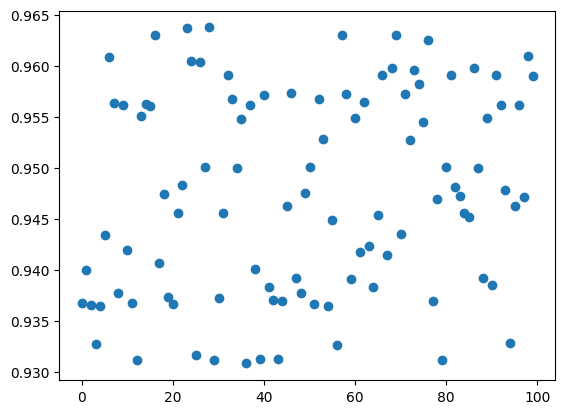

In [ ]:
plt.scatter(range(0,len(loss)), loss)